In [1]:
import pandas as pd
import re

from PIL import Image # used for loading images
import numpy as np
import os # used for navigating to image path
import imageio # used for writing images

import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import tensorflow.keras as keras

import matplotlib.pyplot as plt
#garbage collection impedes my ability to append to large lists (which is important when
#organizing the images in array form), so I turned it off. this doesn't impact the code
#and I am not using any reference loops so there isn't a problem with this.
import gc as gc
gc.disable()


categories = ["topwear","bottomwear","innerwear","bags","watches","jewellery","eyewear","wallets","shoes","sandal","makeup","fragrance","others"]
def sort_labels(string):
    #brings all strings to lowercase
    string = str(string)
    string = string.lower()
    for category in categories:
        if category in string:
            return category
def sort_image_ids(string):
    #making sure it is a string!
    string = string.replace("\\", "")
    #returns all numerical values (aka our image ids)
    string = re.sub("[^0-9]", "",string)
    return string
def clean_description(description):
    #this removes the extra labels that shouldn't be in the description.
    components = (description).split("\t")
    if len(components)==3:
        return components

In [2]:
test = pd.read_csv("test.csv",names = ["imageid"])
#deletes the first empty row
test = test[1:]
test_array = np.array(test["imageid"])

In [3]:
test_image_id = []
test_label = []
test_description = []
for element in test_array:
    temp_image_id,temp_label,temp_description = clean_description(element)
    test_image_id.append(temp_image_id)
    test_label.append(temp_label)
    test_description.append(temp_description)

In [4]:
test_image_arrays = []
test_image_id_new = []
test_label_new = []
test_description_new = []

n = 0
for imageid in test_image_id:
    #load image from folder location
    image = Image.open('C:/adv_comp_phys_images/images/'+imageid+".jpg")
    #resize the image to the standard of our dataset (60,80)
    image = image.resize((60,80))
    # load image as pixel array
    image_data = np.asarray(image)
    if image_data.shape == (80,60,3): #some images seem to not have the RGB value, so we
        test_image_arrays.append(image_data) #exclude them. They produce issues with the
                                            #asarray process and will likely reduce accuracy
        temp_image_id,temp_label,temp_description = clean_description(test_array[n])
        test_image_id_new.append(temp_image_id)
        test_label_new.append(temp_label)
        test_description_new.append(temp_description)
    n+=1
    
#tuns list of arrays into array
test_image_arrays = np.asarray(test_image_arrays)

20865
Sandal
Disney Kids-Unisex Lightning Green Sandals


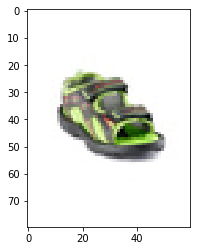

In [5]:
print(test_image_id_new[1000])
print(test_label_new[1000])
print(test_description_new[1000])
plt.imshow(test_image_arrays[1000])
plt.show()

This was just to check the integrity of the process. It produces the image associated with the label, so we can proceed. I will now run the same process for the training images.

In [6]:
gc.disable()
gc.isenabled()

False

In [7]:
train = pd.read_csv("train.csv",names = ["imageid"])
#deletes the first empty row
train = train[1:]
train_array = np.array(train["imageid"])

train_image_id = []
train_label = []
train_description = []
for element in train_array:
    temp_image_id,temp_label,temp_description = clean_description(element)
    train_image_id.append(temp_image_id)
    train_label.append(temp_label)
    train_description.append(temp_description)

train_image_arrays = []
train_image_id_new = []
train_label_new = []
train_description_new = []

n = 0
for imageid in train_image_id:
    #load image from folder location
    image = Image.open('C:/adv_comp_phys_images/images/'+imageid+".jpg")
    #resize the image to the standard of our dataset (60,80)
    image = image.resize((60,80))
    # load image as pixel array
    image_data = np.asarray(image)
    if image_data.shape == (80,60,3): #some images seem to not have the RGB value, so we
        train_image_arrays.append(image_data) #exclude them. They produce issues with the
                                            #asarray process and will likely reduce accuracy
        temp_image_id,temp_label,temp_description = clean_description(train_array[n])
        train_image_id_new.append(temp_image_id)
        train_label_new.append(temp_label)
        train_description_new.append(temp_description)
    n+=1
train_image_arrays = np.asarray(train_image_arrays)

I found that the above cell took a very long time to run. I beleive this is because the list requires a lot of memory due to Python's garbage collector (after writing this I went back and fixed the issue by disabling the garbage collector, which significantly decreased the runtime).

I didn't do this before, but I need to change the labels into digits, so I'll do that below.

In [8]:
def turn_labels_into_digits(label):
    if label.upper() == "TOPWEAR":
        return np.array([1])
    if label.upper() == "BOTTOMWEAR":
        return np.array([2])
    if label.upper() == "INNERWEAR":
        return np.array([3])
    if label.upper() == "BAGS":
        return np.array([4])
    if label.upper() == "WATCHES":
        return np.array([5])
    if label.upper() == "JEWELLERY":
        return np.array([6])
    if label.upper() == "EYEWEAR":
        return np.array([7])
    if label.upper() == "WALLETS":
        return np.array([8])
    if label.upper() == "SHOES":
        return np.array([9])
    if label.upper() == "SANDAL":
        return np.array([10])
    if label.upper() == "MAKEUP":
        return np.array([11])
    if label.upper() == "FRAGRANCE":
        return np.array([12])
    if label.upper() == "OTHERS":
        return np.array([13])

In [9]:
n=0
for label in train_label_new:
    train_label_new[n] = turn_labels_into_digits(label)
    n+=1
train_label_new = np.asarray(train_label_new)
    
n=0
for label in test_label_new:
    test_label_new[n] = turn_labels_into_digits(label)
    n+=1
test_label_new = np.asarray(test_label_new)

In [10]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(60, 80, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(60, 80, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(60, 80, 3)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(14))

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_image_arrays, train_label_new, epochs=3, 
                    validation_data=(test_image_arrays, test_label_new))

Epoch 1/3
1252/1252 [==============================] - 107s 85ms/step - loss: 4.2762 - accuracy: 0.7452 - val_loss: 0.4631 - val_accuracy: 0.8544
Epoch 2/3
1252/1252 [==============================] - 106s 85ms/step - loss: 0.3416 - accuracy: 0.8950 - val_loss: 0.3265 - val_accuracy: 0.8989
Epoch 3/3
1252/1252 [==============================] - 106s 85ms/step - loss: 0.2672 - accuracy: 0.9149 - val_loss: 0.3309 - val_accuracy: 0.8994


At around three layers we begin to run the risk of overfitting, which is indicated by an increase in the accuracy and a decrease in the valence accuracy. This doesn't always happen but it happens occasionally when we run the CNN.

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 58, 78, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 39, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 18, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 16, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 11264)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                7

124/124 - 3s - loss: 0.3309 - accuracy: 0.8994


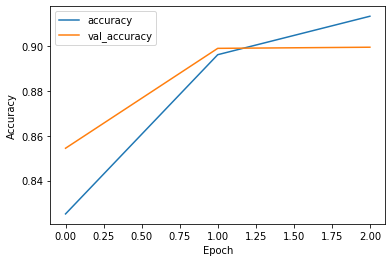

In [13]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

test_loss, test_acc = model.evaluate(test_image_arrays,  test_label_new, verbose=2)

We have a rather well preforming model! Now we will try to alter our approach in order to approve upon it. Here are the most straightforward ways of improving it:
- reducing the pixel values from 0-255. CNNs work best with values between 0-1, and our pixels are represented by a value 
- adding the item description to the data. I think this will be especially useful because there are many keywords in the data which provide important context to the image.

I beleive that removing the RGB dimension may also impact the accuracy, ut I am not sure if it will be effective for reasons outlined in the pdf.

In [14]:
normalized_train_image_arrays = train_image_arrays/255
normalized_test_image_arrays = test_image_arrays/255

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(normalized_train_image_arrays, train_label_new, epochs=3, 
                    validation_data=(normalized_test_image_arrays, test_label_new))

Epoch 1/3
1252/1252 [==============================] - 105s 83ms/step - loss: 0.5675 - accuracy: 0.8247 - val_loss: 0.2562 - val_accuracy: 0.9212
Epoch 2/3
1252/1252 [==============================] - 102s 82ms/step - loss: 0.1852 - accuracy: 0.9427 - val_loss: 0.2065 - val_accuracy: 0.9338
Epoch 3/3
1252/1252 [==============================] - 102s 82ms/step - loss: 0.1285 - accuracy: 0.9581 - val_loss: 0.2474 - val_accuracy: 0.9310


We see an increase in accurracy when we run the CNN after normalizing the pixel data from between 0-255 and 0-1. A simple but effective approach. Next, we will add captions to the image training set.

In [16]:
def add_captions(image_array,caption_array):
    new_image_array = []
    n = 0
    for image in image_array:
        caption = []
        for letter in caption_array[n]:
            caption.append(float(ord(letter)))
        caption = np.asarray(caption).astype(np.float32)
        temp_array = np.stack([image,caption])
        new_image_array.append(temp_array)
        n+=1
    return np.asarray(new_image_array)

def turn_strings_into_numbers(string_array):
    new_string_array = []
    for string in string_array:
        temp_string = np.zeros(100)
        n=0
        for letter in string:
            temp_string[n] = np.array([float(ord(letter))])
            n+=1
        temp_string = np.asarray(temp_string)
        new_string_array.append(temp_string)
    new_string_array = np.asarray(new_string_array)
    return new_string_array

In [17]:
test_description_new_numbered = turn_strings_into_numbers(test_description_new)
train_description_new_numbered = turn_strings_into_numbers(train_description_new)

In [19]:
# Define two input layers
from keras.layers import Input, Concatenate, Conv2D, Flatten, Dense
from keras.models import Model
image_input = Input((80, 60, 3))
vector_input = Input((100,))

# Convolution + Flatten for the image
conv_layer = Conv2D(32, (3,3))(image_input)
flat_layer = Flatten()(conv_layer)

# Concatenate the convolutional features and the vector input
concat_layer= Concatenate()([vector_input, flat_layer])
output = Dense(14)(concat_layer)

# define a model with a list of two inputs
model = Model(inputs=[image_input, vector_input], outputs=output)

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
history = model.fit([normalized_train_image_arrays,train_description_new_numbered], train_label_new, epochs=3, 
                    validation_data=([normalized_test_image_arrays,test_description_new_numbered], test_label_new))

Epoch 1/3
1252/1252 [==============================] - 58s 46ms/step - loss: 3.0391 - accuracy: 0.7011 - val_loss: 0.6922 - val_accuracy: 0.8302
Epoch 2/3
1252/1252 [==============================] - 57s 46ms/step - loss: 0.6322 - accuracy: 0.8483 - val_loss: 0.7723 - val_accuracy: 0.8385
Epoch 3/3
1252/1252 [==============================] - 59s 47ms/step - loss: 0.6209 - accuracy: 0.8678 - val_loss: 0.9914 - val_accuracy: 0.8431


In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 60, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 78, 58, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 144768)       0           conv2d_3[0][0]                   
______________________________________________________________________________________________

Unfortunately, the above method did not work. I am not sure why. When I run it to its specifications (values between [0-1)), I get an accurracy of 0. I think that may be beacuse the output is, for some reason, not categorical but rather a regression type output, which provides a rough guess at the value (for example: 0.5001239 when the value is 0.5). However, at this point I am too tired to figure out why this is the case. Instead I am just going to tweak the image so it is greyscale instead of RGB, combine that with the normalization from 255, and call it a day.

In [23]:
from PIL import ImageOps

test_image_arrays = []
test_image_id_new = []
test_label_new = []
test_description_new = []

n = 0
for imageid in test_image_id:
    #load image from folder location
    image = Image.open('C:/adv_comp_phys_images/images/'+imageid+".jpg")
    #resize the image to the standard of our dataset (60,80)
    image = image.resize((60,80))
    image = ImageOps.grayscale(image)
    # load image as pixel array
    image_data = np.asarray(image)
    if image_data.shape == (80,60): #some images seem to not have the RGB value, so we
        test_image_arrays.append(image_data) #exclude them. They produce issues with the
                                            #asarray process and will likely reduce accuracy
        temp_image_id,temp_label,temp_description = clean_description(test_array[n])
        test_image_id_new.append(temp_image_id)
        test_label_new.append(temp_label)
        test_description_new.append(temp_description)
    n+=1
    
#tuns list of arrays into array
test_image_arrays = np.asarray(test_image_arrays)/255


train_image_arrays = []
train_image_id_new = []
train_label_new = []
train_description_new = []

n = 0
for imageid in train_image_id:
    #load image from folder location
    image = Image.open('C:/adv_comp_phys_images/images/'+imageid+".jpg")
    #resize the image to the standard of our dataset (60,80)
    image = image.resize((60,80))
    image = ImageOps.grayscale(image)
    # load image as pixel array
    image_data = np.asarray(image)
    if image_data.shape == (80,60): #some images seem to not have the RGB value, so we
        train_image_arrays.append(image_data) #exclude them. They produce issues with the
                                            #asarray process and will likely reduce accuracy
        temp_image_id,temp_label,temp_description = clean_description(train_array[n])
        train_image_id_new.append(temp_image_id)
        train_label_new.append(temp_label)
        train_description_new.append(temp_description)
    n+=1
train_image_arrays = np.asarray(train_image_arrays)/255

In [24]:
n=0
for label in train_label_new:
    train_label_new[n] = turn_labels_into_digits(label)
    n+=1
train_label_new = np.asarray(train_label_new)
    
n=0
for label in test_label_new:
    test_label_new[n] = turn_labels_into_digits(label)
    n+=1
test_label_new = np.asarray(test_label_new)

In [25]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(60, 80,1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(60, 80,1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(60, 80,1)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(14))

In [26]:
test_image_arrays_new = test_image_arrays.reshape(len(test_image_arrays), 60, 80, 1)
train_image_arrays_new = train_image_arrays.reshape(len(train_image_arrays), 60, 80, 1)

In [27]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
history = model.fit(train_image_arrays_new, train_label_new, epochs=3, 
                    validation_data=(test_image_arrays_new, test_label_new))

Epoch 1/3
1264/1264 [==============================] - 100s 79ms/step - loss: 0.8830 - accuracy: 0.7251 - val_loss: 0.3800 - val_accuracy: 0.8860
Epoch 2/3
1264/1264 [==============================] - 101s 80ms/step - loss: 0.3155 - accuracy: 0.9019 - val_loss: 0.2823 - val_accuracy: 0.9137
Epoch 3/3
1264/1264 [==============================] - 98s 78ms/step - loss: 0.2305 - accuracy: 0.9248 - val_loss: 0.2558 - val_accuracy: 0.9208
